**----------程式說明:此程式用來將raw data合併並且只保留必要欄位以利後續分析----------**  
**1. 第一個程式區塊遍歷指定年份中所有壓縮檔並且解壓縮**  
**2. 第二個程式區塊將指定年份月分中csv檔案合併並且只保留需要欄位，同時第一次計算年度資料筆數**  
**3. 第三個程式區塊將合併完的月度csv讀進程式合併成年度csv，並且匯出成若干parquet檔案**  
**4. 第四個程式區塊第二次計算年度資料筆數並且把多餘檔案刪除**  

In [1]:
import pandas as pd 
import os  
import gzip
import shutil
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from tqdm import tqdm

**區塊1**

In [163]:
root_folder = "E:\\2025"  # change year here

for month_folder in os.listdir(root_folder):
    month_folder_path = os.path.join(root_folder, month_folder)
    
    if os.path.isdir(month_folder_path):
        
        for subfolder in os.listdir(month_folder_path):
            subfolder_path = os.path.join(month_folder_path, subfolder) # data_*_*_*
                
            if subfolder_path.endswith('.csv.gz'):
                output_file = os.path.splitext(subfolder_path)[0] 
                with gzip.open(subfolder_path, 'rb') as f_in:
                    with open(output_file, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                    print(f"\rUpzip: {output_file}", end="", flush=True)

Upzip: E:\2025\all_for_2025-07-01\data_9_7_0.csvv

**區塊2**

In [164]:
root_folder = "E:\\2025" 
merged_monthly_data = [] # used to merge every month data 

for month_folder in os.listdir(root_folder):
    month_folder_path = os.path.join(root_folder, month_folder)
    
    if os.path.isdir(month_folder_path):
        monthly_data = [] # store all the data in a specific month 
        
        for file in os.listdir(month_folder_path):
            file_path = os.path.join(month_folder_path, file)
            if file.endswith('.csv'):
                df = pd.read_csv(file_path, low_memory=False)
                df = df[['id', 'last_updated_date', 'duplicates', 'posted', 'expired', 'company', 'company_name',
                         'title_name', 'title_clean', 'skills_name', 'specialized_skills_name']]
                monthly_data.append(df)
        
        if monthly_data:
            monthly_merged_df = pd.concat(monthly_data, ignore_index=True)
            monthly_merged_file = os.path.join(root_folder, f"merged_{month_folder}.csv")
            monthly_merged_df.to_csv(monthly_merged_file, index=False)
            print(f"\rAlready merged {month_folder} data and saved as {monthly_merged_file}", end="", flush=True)

Already merged all_for_2025-07-01 data and saved as E:\2025\merged_all_for_2025-07-01.csv

In [165]:
import duckdb

base_dir = r"E:\2025"
con = duckdb.connect()

query = f"""
SELECT 
    COALESCE(filename, 'Total_2025') AS filename,
    COUNT(*) AS nrows
FROM read_csv_auto('{base_dir}/merged_all_for_2025-*.csv',
                   filename=true,
                   delim=',',
                   header=true)
GROUP BY ROLLUP(filename)
ORDER BY filename;
"""

df = con.execute(query).fetchdf()
print(df)


                                filename     nrows
0  E:\2025\merged_all_for_2025-01-01.csv   3419627
1  E:\2025\merged_all_for_2025-02-01.csv   3142403
2  E:\2025\merged_all_for_2025-03-01.csv   3247861
3  E:\2025\merged_all_for_2025-04-01.csv   3311032
4  E:\2025\merged_all_for_2025-05-01.csv   3258479
5  E:\2025\merged_all_for_2025-06-01.csv   3687685
6  E:\2025\merged_all_for_2025-07-01.csv   1810740
7                             Total_2025  21877827


**區塊3**

In [166]:
root_folder = "E:\\2025" 

monthly_csv_files = [
    os.path.join(root_folder, f)
    for f in os.listdir(root_folder)
    if f.startswith("merged_") and f.endswith(".csv")
]

print("Found CSV files to merge:")
for f in monthly_csv_files:
    print(f)

ddf = dd.read_csv(monthly_csv_files, assume_missing=True) 
output_folder = os.path.join(root_folder, "trimmed_2025_parquet")

with ProgressBar():
    ddf.to_parquet(output_folder)

print(f"Saved as: {output_folder}")

Found CSV files to merge:
E:\2025\merged_all_for_2025-01-01.csv
E:\2025\merged_all_for_2025-02-01.csv
E:\2025\merged_all_for_2025-03-01.csv
E:\2025\merged_all_for_2025-04-01.csv
E:\2025\merged_all_for_2025-05-01.csv
E:\2025\merged_all_for_2025-06-01.csv
E:\2025\merged_all_for_2025-07-01.csv
[########################################] | 100% Completed | 325.39 s
Saved as: E:\2025\trimmed_2025_parquet


**區塊4**

In [167]:
folder_path = "E:\\2025\\trimmed_2025_parquet"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".parquet")]
total_rows = 0
total_files = len(all_files)

for i, f in enumerate(all_files, start=1):
    df = pd.read_parquet(f)
    total_rows += len(df)
    print(f"\rProcessing file {i}/{total_files}: {os.path.basename(f)} | Total rows so far: {total_rows}", end="", flush=True)

print(f"\nFinished! Total rows: {total_rows}")

Processing file 180/180: part.99.parquet | Total rows so far: 21877827
Finished! Total rows: 21877827


In [168]:
year_folder = "E:\\2025"

for month_folder in os.listdir(year_folder):
    month_folder_path = os.path.join(year_folder, month_folder)
    
    if os.path.isdir(month_folder_path):
        for file in os.listdir(month_folder_path):
            file_path = os.path.join(month_folder_path, file)
            
            if os.path.isfile(file_path) and file.endswith(".csv"):
                os.remove(file_path)
                print(f"Deleted: {file_path}")

print("Done! All CSV files in 2025 have been deleted.")

Deleted: E:\2025\all_for_2025-01-01\data_0_0_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_1_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_2_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_3_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_4_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_5_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_6_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_0_7_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_0_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_1_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_2_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_3_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_4_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_5_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_6_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_10_7_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_11_0_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_11_1_0.csv
Deleted: E:\2025\all_for_2025-01-01\data_11_2_0.csv
Deleted: E:\2025\all

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

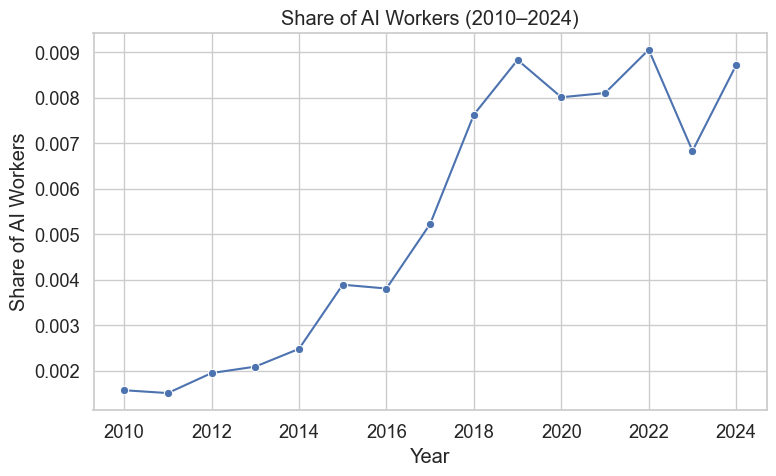

In [23]:
data_2010 = pd.read_parquet("E:\\out\\2010_job_ai_scores.parquet")
data_2011 = pd.read_parquet("E:\\out\\2011_job_ai_scores.parquet")
data_2012 = pd.read_parquet("E:\\out\\2012_job_ai_scores.parquet")
data_2013 = pd.read_parquet("E:\\out\\2013_job_ai_scores.parquet")
data_2014 = pd.read_parquet("E:\\out\\2014_job_ai_scores.parquet")
data_2015 = pd.read_parquet("E:\\out\\2015_job_ai_scores.parquet")
data_2016 = pd.read_parquet("E:\\out\\2016_job_ai_scores.parquet")
data_2017 = pd.read_parquet("E:\\out\\2017_job_ai_scores.parquet")
data_2018 = pd.read_parquet("E:\\out\\2018_job_ai_scores.parquet")
data_2019 = pd.read_parquet("E:\\out\\2019_job_ai_scores.parquet")
data_2020 = pd.read_parquet("E:\\out\\2020_job_ai_scores.parquet")
data_2021 = pd.read_parquet("E:\\out\\2021_job_ai_scores.parquet")
data_2022 = pd.read_parquet("E:\\out\\2022_job_ai_scores.parquet")
data_2023 = pd.read_parquet("E:\\out\\2023_job_ai_scores.parquet")
data_2024 = pd.read_parquet("E:\\out\\2024_job_ai_scores.parquet")
f10 = data_2010['ai_job'].mean()
f11 = data_2011['ai_job'].mean()
f12 = data_2012['ai_job'].mean()
f13 = data_2013['ai_job'].mean()
f14 = data_2014['ai_job'].mean()
f15 = data_2015['ai_job'].mean()
f16 = data_2016['ai_job'].mean()
f17 = data_2017['ai_job'].mean()
f18 = data_2018['ai_job'].mean()
f19 = data_2019['ai_job'].mean()
f20 = data_2020['ai_job'].mean()
f21 = data_2021['ai_job'].mean()
f22 = data_2022['ai_job'].mean()
f23 = data_2023['ai_job'].mean()
f24 = data_2024['ai_job'].mean()

data = pd.DataFrame({
    "Year": [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    "Share_of_AI_workers": [f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24]
})

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8,5))
sns.lineplot(data=data, x="Year", y="Share_of_AI_workers", marker="o")

plt.title("Share of AI Workers (2010–2024)")
plt.xlabel("Year")
plt.ylabel("Share of AI Workers")
plt.tight_layout()
plt.show()

In [10]:
data = pd.read_parquet("D:\\merged.parquet")
data[['id']==1005022350469]

KeyError: False

In [11]:
df = pd.read_parquet("D:\\temp1.parquet")
df

,id,title_name,company_name_raw,description_raw,year,ai_related,first_hit_skill
0,1005022350469,senior principal sourcing npi,PerkinElmer,Lead end to end procurement solution to new pr...,2019,0,None
1,1005022350469,senior principal sourcing npi,PerkinElmer,Lead end to end procurement solution to new pr...,2020,0,None
2,1005022350469,senior principal sourcing npi,PerkinElmer,Lead end to end procurement solution to new pr...,2021,0,None
3,1005022350469,senior principal sourcing npi,PerkinElmer,Lead end to end procurement solution to new pr...,2022,0,None
4,1005022350469,senior principal sourcing npi,PerkinElmer,Lead end to end procurement solution to new pr...,2023,0,None
...,...,...,...,...,...,...,...
9740981,996433173831,Senior Engineer,Trion Worlds,Senior UI Engineer at Trion Worlds. Lead devel...,2023,0,None
9740982,996433173831,Senior Engineer,Trion Worlds,Senior UI Engineer at Trion Worlds. Lead devel...,2024,0,None
9740983,996433173831,Senior Engineer,Trion Worlds,Senior UI Engineer at Trion Worlds. Lead devel...,2025,0,None
9740984,99675,Sales Associate,Dick's Sporting Goods,As a Footwear Associate at Dick’s Sporting Goo...,2024,0,None


In [2]:
df2 = pd.read_parquet("D:\\temp2.parquet")
df2

,company_name,year,employees,ai_employees,ai_measure
0,Baptist Health Care Northwest Florida,1978,1,0.0,0.0
1,Baptist Health Care Northwest Florida,1979,2,0.0,0.0
2,Baptist Health Care Northwest Florida,1980,2,0.0,0.0
3,Baptist Health Care Northwest Florida,1981,2,0.0,0.0
4,Baptist Health Care Northwest Florida,1982,2,0.0,0.0
...,...,...,...,...,...
58335516,🤫 Stealth Co.,2021,1,0.0,0.0
58335517,🤫 Stealth Co.,2022,1,0.0,0.0
58335518,🤫 Stealth Co.,2023,2,0.0,0.0
58335519,🤫 Stealth Co.,2024,1,0.0,0.0
